
> Descrição do Desafio

O desafio consiste com relação ao método de "transfer learning" em uma rede de Deep Learning na linguagem Python utilizando Dataset com imagens de cachorros e gatos.




In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True) 

Mounted at /content/drive


In [ ]:
#Importando as bibliotecas
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Iniciando a taxa de aprendizado inicial, épocas e o tamanho do lote
INIT_LR = 1e-4
EPOCHS = 10
BS = 32

In [12]:
train_dir ='/content/drive/MyDrive/images_datasets'
CATEGORIES = ['cats','dogs']

print("[INFO] loading images...")
data = []
labels = []

[INFO] loading images...


In [13]:
#Categorizar as imagens
for category in CATEGORIES:
    path = os.path.join(train_dir, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224,224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

In [14]:
#Encoding os labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

In [15]:
#Divisão dos dados de treino e teste 
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

In [16]:
#Construindo o gerador de imagem de treinamento para aumento de dados
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [17]:
#Carregando o modelo MobileNetV2 do keras. Este modelo utiliza os pesos da ImageNet.
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

#Criando camadas base do modelo para o aprendizado
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

9406464/9406464 [==============================] - 0s 0us/step


In [18]:
#Loop para atualização após o primeiro processo de treinamento
for layer in baseModel.layers:
	layer.trainable = False

#Compilar modelo
print("[INFO] Compilando o modelo...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

[INFO] Compilando o modelo...


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [19]:
#Incializando o processo de treinamento da rede MobileNetV2
print("[INFO] Inicializando o treinamento...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] Inicializando o treinamento...
Epoch 1/10
18/18 [==============================] - 33s 2s/step - loss: 0.6996 - accuracy: 0.6094 - val_loss: 0.4950 - val_accuracy: 0.7986
Epoch 2/10
18/18 [==============================] - 28s 2s/step - loss: 0.4677 - accuracy: 0.8229 - val_loss: 0.3604 - val_accuracy: 0.9236
Epoch 3/10
18/18 [==============================] - 28s 2s/step - loss: 0.3617 - accuracy: 0.8993 - val_loss: 0.2716 - val_accuracy: 0.9583
Epoch 4/10
18/18 [==============================] - 28s 2s/step - loss: 0.2720 - accuracy: 0.9375 - val_loss: 0.2106 - val_accuracy: 0.9583
Epoch 5/10
18/18 [==============================] - 28s 2s/step - loss: 0.2305 - accuracy: 0.9340 - val_loss: 0.1705 - val_accuracy: 0.9653
Epoch 6/10
18/18 [==============================] - 28s 2s/step - loss: 0.2014 - accuracy: 0.9479 - val_loss: 0.1420 - val_accuracy: 0.9861
Epoch 7/10
18/18 [==============================] - 28s 2s/step - loss: 0.1691 - accuracy: 0.9618 - val_loss: 0.1227 - val

In [20]:
#Previsões sobre o conjunto de testes
print("[INFO] Evoluindo a rede...")
predIdxs = model.predict(testX, batch_size=BS)

#Para cada imagem no conjunto de teste, precisamos encontrar o índice do rótulo com a maior probabilidade prevista correspondente
predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

#salvar o modelo treinado
print("[INFO] Salvando o modelo de detector de Gato e Cachorro...")
model.save("cat-and-dog_detector.model", save_format="h5")

[INFO] Evoluindo a rede...
5/5 [==============================] - 5s 849ms/step
              precision    recall  f1-score   support

        cats       1.00      0.97      0.99        40
        dogs       0.99      1.00      1.00       104

    accuracy                           0.99       144
   macro avg       1.00      0.99      0.99       144
weighted avg       0.99      0.99      0.99       144

[INFO] Salvando o modelo de detector de Gato e Cachorro...


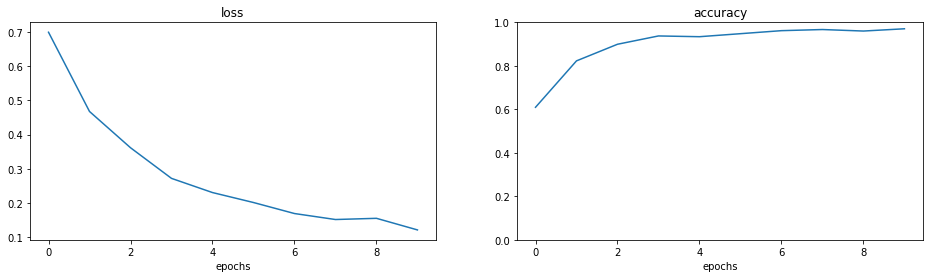

In [21]:
#Utilizando Matplot para exibir gráfico
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(H.history["loss"])
ax.set_title("loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(H.history["accuracy"])
ax2.set_title("accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [22]:
#Importando as bibliotecas para realização de testes
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import argparse
import imutils
import time
import cv2
import os

[INFO] Carregando o treinamento do modelo de classificação de Gatos e Cachorros...
1/1 [==============================] - 1s 1s/step


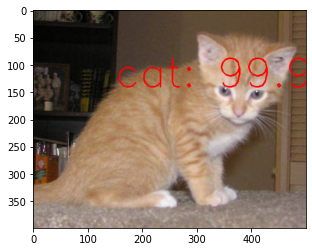

In [30]:
#Teste GATO
print("[INFO] Carregando o treinamento do modelo de classificação de Gatos e Cachorros...")
model = tf.keras.models.load_model('cat-and-dog_detector.model')
image = cv2.imread("/content/drive/MyDrive/images_datasets/cats/cat.4003.jpg")
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))
img = img_to_array(img)
img = preprocess_input(img)
img = np.expand_dims(img, axis=0)
(dog,cat) = model.predict(img)[0]
label = "dog" if dog < cat else "cat"
color = (0, 255, 0) if label == "dog" else (0, 0, 255)
label = "{}: {:.2f}%".format(label, max(dog, cat) * 100)
cv2.putText(image, label, (150, 150 - 10),
cv2.FONT_HERSHEY_SIMPLEX, 2.5, color, 2)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

[INFO] Carregando o treinamento do modelo de classificação de Gatos e Cachorros...
1/1 [==============================] - 1s 996ms/step


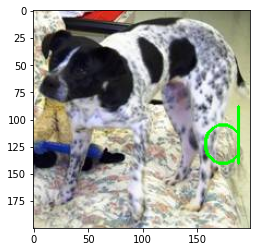

In [31]:
#Teste Cachorro
print("[INFO] Carregando o treinamento do modelo de classificação de Gatos e Cachorros...")
model = tf.keras.models.load_model('cat-and-dog_detector.model')
image = cv2.imread("/content/drive/MyDrive/images_datasets/dogs/dog.4356.jpg")
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))
img = img_to_array(img)
img = preprocess_input(img)
img = np.expand_dims(img, axis=0)
(dog,cat) = model.predict(img)[0]
label = "dog" if dog < cat else "cat"
color = (0, 255, 0) if label == "dog" else (0, 0, 255)
label = "{}: {:.2f}%".format(label, max(dog, cat) * 100)
cv2.putText(image, label, (150, 150 - 10),
cv2.FONT_HERSHEY_SIMPLEX, 2.5, color, 2)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

[INFO] Carregando o treinamento do modelo de classificação de Gatos e Cachorros...
1/1 [==============================] - 1s 979ms/step


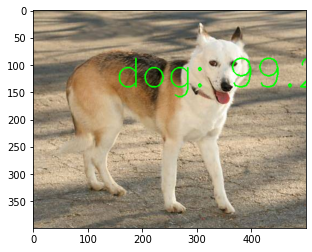

In [32]:
#Teste Cachorro 
print("[INFO] Carregando o treinamento do modelo de classificação de Gatos e Cachorros...")
model = tf.keras.models.load_model('cat-and-dog_detector.model')
image = cv2.imread("/content/drive/MyDrive/images_datasets/dogs/dog.4518.jpg")
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))
img = img_to_array(img)
img = preprocess_input(img)
img = np.expand_dims(img, axis=0)
(dog,cat) = model.predict(img)[0]
label = "dog" if dog < cat else "cat"
color = (0, 255, 0) if label == "dog" else (0, 0, 255)
label = "{}: {:.2f}%".format(label, max(dog, cat) * 100)
cv2.putText(image, label, (150, 150 - 10),
cv2.FONT_HERSHEY_SIMPLEX, 2.5, color, 2)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()